# Decision Tree

In diesem Notebook wird ein Modelltraining mit Entscheidungsbäumen durchgeführt. 

Die Datenvorbereitung wurde in einem vorherigen Notebook abgeschlossen, sodass hier der Fokus auf dem Trainingsprozess liegt. Das Decision Tree-Modell wird trainiert und die Ergebnisse evaluiert. Zudem werden die Auswirkungen von Hyperparameteranpassungen untersucht.

## 1. Laden der Daten

In [1]:
import geopandas as gpd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# für Visualisierung
import matplotlib.pyplot as plt

In [2]:
# GeoJSON-Datei laden
gdf = gpd.read_file('../../../data/processed_data/simra_osm_all.geojson')

In [3]:
gdf.head(2)

,id,type,score,incidents,rides,index_right,maxspeed,asphalt,concrete,paving_stone,...,highway_rare,living_street,path,primary,residential,secondary,service,tertiary,track,geometry
0,[100049].0,Street,0.0,0,138,57832.0,50,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,"POLYGON ((13.45412 52.54035, 13.4532 52.53977,..."
1,[100069498].0,Junction,0.0,0,200,123443.0,30,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,"POLYGON ((13.52273 52.50704, 13.52248 52.5069,..."


In [4]:
gdf.columns

Index(['id', 'type', 'score', 'incidents', 'rides', 'index_right', 'maxspeed',
       'asphalt', 'concrete', 'paving_stone', 'sett', 'unpaved', 'markers',
       'highway', 'cycleway', 'footway', 'highway_rare', 'living_street',
       'path', 'primary', 'residential', 'secondary', 'service', 'tertiary',
       'track', 'geometry'],
      dtype='object')

### Geometrische und nicht relevante Daten entfernen:
- `type` (junction oder street) wird auch entfernt, da diese Informationen nicht in den OSM-Segmenten enthalten sind (Die Information aus OSM nutzen wir als Prädiktoren für unsere Vorhersage des Gefahrenpotenzials).

In [5]:
df = gdf.drop(columns=['markers', 'id', 'index_right', 'geometry', 'highway', 'incidents', 'rides', 'type'])

In [6]:
df.head(2)

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,service,tertiary,track
0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0
1,0.0,30,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0


### Feature- und Zielvariablen definieren

In [7]:
# Zielvariable (Score) definieren
y = df['score']

In [8]:
# Alle anderen Spalten als Features verwenden 
X = df.drop(columns=['score'])

### Trainings- und Testdaten splitten
- 80% Trainingsdaten, 20 % Testdaten

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Anzahl der Trainingsdaten: {X_train.shape[0]}")
print(f"Anzahl der Testdaten: {X_test.shape[0]}")

Anzahl der Trainingsdaten: 12529
Anzahl der Testdaten: 3133


## 2. Einfaches Decision Tree-Modell traininieren 

#### Modell initialisieren und trainieren

In [10]:
# Fit des Decision Tree Regressors
dt = DecisionTreeRegressor(random_state=1)

In [11]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

#### R²-Koeffizient (Bestimmtheitsmaß) auf den Trainingsdaten

In [12]:
r2_train = dt.score(X_train, y_train)
r2_train

0.5408956489513211

### Visualsierung des Entscheidungsbaums

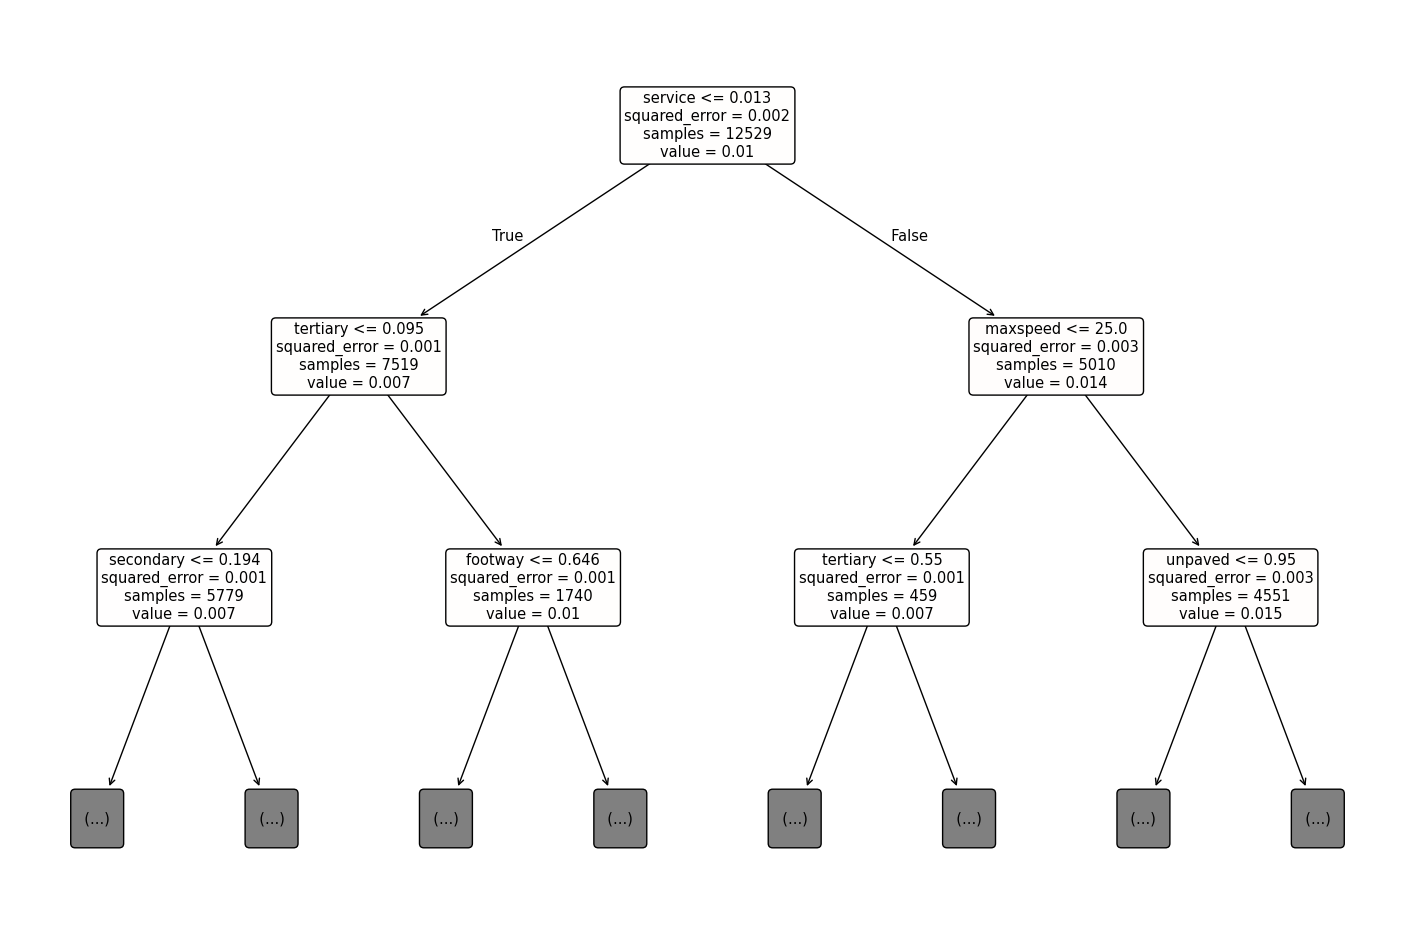

In [13]:
fig = plt.figure(figsize=(18,12))
_ = tree.plot_tree(dt, feature_names=X.columns, filled=True, rounded=True, max_depth = 2)

## Vorhersage auf den Testdaten & Bewertung

In [14]:
y_pred = dt.predict(X_test)

####  Modellbewertung: MSE und R²-Score

In [15]:
# Metriken berechnen
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [16]:
# Ergebnisse
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 0.0035374246507438516
Mean Absolute Error (MAE): 0.017543801590384957
Root Mean Squared Error (RMSE): 0.05947625283038476
R^2 Score: -0.378305541636238


### Fehlermetriken

- **`r2_score` (Bestimmtheitsmaß)**: Bestimmtheitsmaß, das die Güte der Anpassung des Modells angibt.
  - Ein Maß dafür, wie gut die Vorhersagen des Modells die Varianz in den tatsächlichen Zielwerten erklären.
  - Interpretation: Ein R^2-Score von 1 bedeutet perfekte Vorhersage, ein Wert von 0 bedeutet, dass das Modell nicht besser als der Mittelwert der Zielvariable ist. Negative Werte können auftreten, wenn das Modell schlechter ist als ein einfaches Modell, das immer den Mittelwert vorhersagt. R^2 zeigt an, wie gut das Modell die Zielvariabilität erklärt.
- **`mean_absolute_error`**: Durchschnittlicher absoluter Fehler.
  - Der Durchschnitt der absoluten Unterschiede zwischen den vorhergesagten Werten und den tatsächlichen Werten.
  - Interpretation: MAE gibt den durchschnittlichen absoluten Fehler des Modells in den gleichen Einheiten wie die Zielvariable an. Ein niedriger MAE bedeutet, dass das Modell im Durchschnitt geringe Fehler macht. MAE ist robust gegenüber Ausreißern, da alle Fehler gleich gewichtet werden.
- **`mean_squared_error`**: Durchschnittlicher quadratischer Fehler.
  - Der Durchschnitt der quadratischen Unterschiede zwischen den vorhergesagten Werten und den tatsächlichen Werten.
  - Interpretation: MSE bestraft größere Fehler stärker als kleinere Fehler, da die Fehlerquadrate verwendet werden. Ein niedriger MSE zeigt eine gute Modellanpassung an. MSE kann jedoch empfindlich gegenüber Ausreißern sein, da große Fehler quadratisch stärker gewichtet werden.
- **`root_mean_squared_error` sqrt von MSE**: Wurzel des mittleren quadratischen Fehlers (RMSE).
  - Die Quadratwurzel des Mittelwerts der quadratischen Fehler (MSE).
  - Interpretation: RMSE gibt die durchschnittliche Abweichung der Vorhersagen in den gleichen Einheiten wie die Zielvariable an. Es ist leichter zu interpretieren als der MSE, da es die Fehler in der gleichen Einheit wie die Zielvariable zurückgibt. RMSE ist ebenfalls empfindlich gegenüber großen Fehlern.

### Interpretation der Ergebnisse: 
- **MSE** und **RMSE** zeigen, dass die durchschnittlichen quadratischen Fehler und absoluten Fehler relativ klein sind. Dies könnte jedoch täuschen, weil eine stark unausgewogene Zielvariable die Fehlermetrik verzerren kann.
- Ein **MAE** von etwa 0.0175 könnte darauf hinweisen, dass das Modell gut darin ist, nahe null liegende Werte vorherzusagen, scheitert jedoch an den selteneren höheren Werten.
- **R²-Score**: Ein Wert von -0.378 deutet darauf hin, dass das Modell nicht nur schlecht ist, sondern auch schlechter als ein einfaches Mittelwertmodell, was darauf hinweist, dass das Modell möglicherweise die Struktur der Daten nicht gut erfasst oder dass die hohe Konzentration der Zielvariablen auf Null die Modellleistung stark beeinträchtigt.

#### Starke Unausgewogenheit der Zielvariable

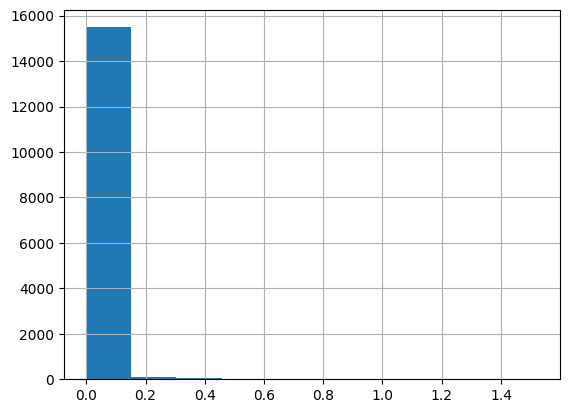

In [17]:
# Histogramm
df['score'].hist();

### Feature Importance

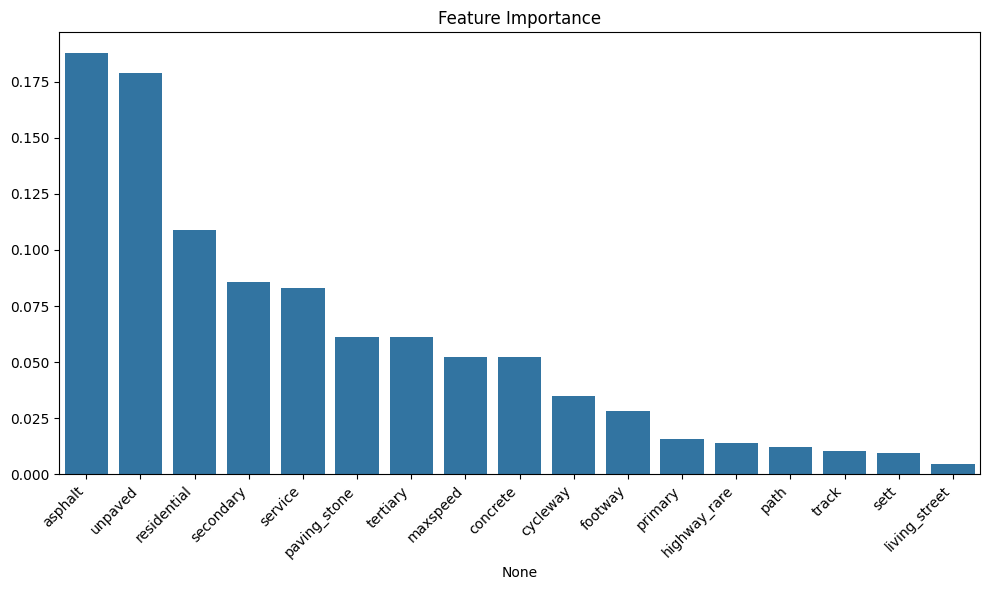

In [18]:
import numpy as np
import seaborn as sns

# Feature Importance extrahieren
importance = dt.feature_importances_

# Sortieren der Features nach Wichtigkeit
sorted_indices = np.argsort(importance)[::-1]

# Plot mit rotierter Achsenbeschriftung
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns[sorted_indices], y=importance[sorted_indices])
plt.xticks(rotation=45, ha='right')  # Beschriftung um 45 Grad rotieren
plt.title('Feature Importance')
plt.tight_layout()  # Automatische Anpassung des Layouts
plt.show()


## 3. Hyperparamtertuning mit GridSearch

Um die besten Hyperparameter zu finden, wird **Grid Search** in Kombination mit **Cross-Validation** genutzt.

#### Hyperparameter-Raum definieren

Im Fall eines Decision Tree-Regressors gibt es mehrere Hyperparameter, die optimiert werden können:

- `max_depth`: Maximale Tiefe des Baums.
- `min_samples_split`: Mindestanzahl von Samples, die notwendig sind, um einen Knoten zu teilen.
- `min_samples_leaf`: Mindestanzahl von Samples in einem Blatt.
- `max_features`: Maximale Anzahl von Features, die verwendet werden dürfen.

In [19]:
from sklearn.model_selection import GridSearchCV

# Definiere den Hyperparameter-Raum (inklusive max_features)
param_grid = {
    'max_depth': range(1, 21),  # Baumtiefen
    'min_samples_split': [2, 5, 10, 20],  # minimale Anzahl an Samples für Splits
    'min_samples_leaf': [1, 2, 4, 10],  # minimale Anzahl an Samples in einem Blatt
    'max_features': [None, 'sqrt', 'log2', 0.5]  # Werte für max_features
}

In [20]:
# Grid Search einrichten
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

In [21]:
# Grid Search ausführen
grid_search.fit(X_train, y_train)

/Users/smatthies/Documents/FIW/environments/ikt/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(1, 21),
                         'max_features': [None, 'sqrt', 'log2', 0.5],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='r2')

In [22]:
# Beste Parameter ansehen und Modell bewerten
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [23]:
# Modellvorhersagen treffen
y_pred = best_model.predict(X_test)

In [24]:
# Metriken berechnen
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [25]:
# Ergebnisse ausgeben
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 0.0025629199994621115
Mean Absolute Error (MAE): 0.01583723983392277
Root Mean Squared Error (RMSE): 0.050625290117313024
R^2 Score: 0.0013958778496783175


### Interpretation: 
- Die Werte werden auch nach dem Hyperparametertuning nicht wesentlich besser. 
- `R^2 Score`: Der Wert von 0,0013 deutet darauf hin, dass das Modell kaum Varianz erklärt und die die Struktur der Daten nicht gut zu fasst.


##  4. Cross-Validation (mit 5 Folds) 

#### Ablauf: 
- Der Datensatz wird in 5 Teile aufgeteilt.
- Das Modell wird 5 Mal trainiert, jedes Mal wird einer der 5 Teile als Testset verwendet und die anderen 4 Teile dienen zum Training.
- Die Fehlermetriken werden für jeden Durchlauf berechnet.
- Die finale Modellleistung wird als Durchschnitt der 5 Testergebnisse angegeben.

#### Vorteile von Cross-Validation:

- **Stabilere Leistungsbewertung**: Da das Modell auf verschiedenen Datensplits trainiert und getestet wird, ist die Schätzung der Modellleistung verlässlicher.

In [26]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer

In [27]:
# CV des besten Modells
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

In [28]:
from sklearn.model_selection import cross_validate

# Scoring-Metriken definieren
scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(root_mean_squared_error)
}

# Cross-Validation des besten Modells auf dem gesamten Trainingsdatensatz
cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Durchschnittliche Ergebnisse
print("Durchschnittliche Ergebnisse über die 5 Folds:")
print(f"R^2 Score: {cv_results['test_R2'].mean()}")
print(f"Mean Absolute Error (MAE): {cv_results['test_MAE'].mean()}")
print(f"Mean Squared Error (MSE): {cv_results['test_MSE'].mean()}")
print(f"Root Mean Squared Error (RMSE): {cv_results['test_RMSE'].mean()}")


Durchschnittliche Ergebnisse über die 5 Folds:
R^2 Score: 0.004685730228648532
Mean Absolute Error (MAE): 0.015202550300088404
Mean Squared Error (MSE): 0.0016714996155239553
Root Mean Squared Error (RMSE): 0.04064048966136188


### Interpretation: 
Zusammenfassung und Interpretation:
- Die niedrigen Werte für MAE, MSE und RMSE zeigen, dass das Modell insgesamt präzise Vorhersagen macht, insbesondere bei den häufigeren niedrigen Werten der Zielvariable.
- Der R²-Wert bleibt aber sehr niedrig, was darauf hinweist, dass das Modell fast keine Varianz in den Daten erklärt.

Das könnte folgende Ursachen haben: 
  1. Die Zielvariable ist so stark unausgewogen, dass das Modell Schwierigkeiten hat, die seltenen höheren Werte genau vorherzusagen, was zu einem niedrigen R²-Wert führt.
  2. Ihr Modell könnte möglicherweise zu einfach sein (Underfitting) oder nicht gut auf die zugrunde liegenden Muster in den Daten abgestimmt sein.


### Warum könnte das Modell schlecht performen?

- **Unausgewogene Daten**: Wenn die Zielvariable stark unausgewogen ist (die meisten Werte liegen bei 0 und wenige um 1), kann das Modell Schwierigkeiten haben, die seltenen Werte korrekt vorherzusagen. &rarr; kann so dazu neigen, die häufigere Klasse zu überrepräsentieren und die seltenere Klasse zu ignorieren.
- **Decision-Komplexität**: Ein Entscheidungsbaum ist möglicherweise nicht flexibel oder leistungsfähig genug, um die Struktur in deinen Daten korrekt zu erfassen.
- **Feature Engineering**: Die vorhandenen Features liefern möglicherweise nicht genügend Informationen oder die relevanten Merkmale für das Modell.
- Hyperparameter: Obwohl Hyperparameter-Tuning durchgeführt wurde, sind die optimalen Parameter möglicherweise immer noch nicht ideal oder das Modell ist zu stark regularisiert. &rarr; ist in dem Fall eher unwahrscheinlich


## Ansatz zum Umgang mit der Zielvariable: Skalierung oder Transformation der Zielvariable

Bei der Verwendung von Entscheidungsbäumen wie dem `DecisionTreeRegressor` ist die Notwendigkeit zur Skalierung oder Transformation der Zielvariablen weniger ausgeprägt. Entscheidungsbäume sind nicht besonders anfällig für die Skalierung der Zielvariablen, da sie auf Basis von Splits in den Eingabefeatures arbeiten und nicht direkt von der Skala der Zielvariablen beeinflusst werden.

Jedoch können Transformationen der Zielvariablen in bestimmten Fällen hilfreich sein, insbesondere wenn mit einer sehr unausgewogenen Verteilung der Zielvariablen umgegangen werden soll.

Eine mögliche Transfomation für Entscheidungsbäume:
#### Log-Transformation
- Wann anwenden?: Wenn die Zielvariable stark schief verteilt ist und große Ausreißer oder hohe Werte aufweist. Die Log-Transformation kann helfen, die Verteilung zu normalisieren.
- Transformation:
    - `y_log = np.log1p(y)` (Log-Transformation mit `np.log1p`, um log(1 + y) zu verwenden und negative Werte zu vermeiden.)
    - Rücktransformation: Nach der Vorhersage, wird `np.expm1(pred)` für die Rücktransformation der Vorhersagen verwendet.
- Vorteil: Reduziert die Auswirkungen extremer Werte und kann die Modellleistung verbessern, wenn die Zielvariable eine starke Schiefe aufweist.

In [29]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Log-Transformation der Zielvariable
y_train_log = np.log1p(y_train) # np.log1p(y) ist log(1 + y), um negative Werte zu vermeiden
y_test_log = np.log1p(y_test)

In [30]:
# Training des best_models mit der log-transformierten Zielvariable
best_model.fit(X_train, y_train_log)

DecisionTreeRegressor(max_depth=2, max_features='sqrt', min_samples_leaf=10,
                      random_state=1)

In [31]:
# Vorhersagen und Rücktransformation
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Rücktransformation der Vorhersagen

In [32]:
# Metriken berechnen
y_test_original = np.expm1(y_test_log)  # Rücktransformation der Zielvariable

print(f"R^2 Score: {r2_score(y_test_original, y_pred)}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_original, y_pred)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_original, y_pred)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test_original, y_pred))}")

R^2 Score: 0.0010240395280457504
Mean Absolute Error (MAE): 0.015440142553322257
Mean Squared Error (MSE): 0.00256387432345291
Root Mean Squared Error (RMSE): 0.05063471460819059


#### Interpretation: 
- Auch mit einer Transformation der Zielvariable verbessern sich die Leistungswerte nicht. 

## Ergebnisse:

- Das Modell zeigt eine geringe durchschnittliche Abweichung der Vorhersagen von den tatsächlichen Werten (MAE) und eine geringe Varianz der Fehler (MSE, RMSE).
- Der R2-Score bleibt durchgängig sehr niedrig, was darauf hindeutet, dass das Modell nur einen sehr kleinen Teil der Varianz in den Daten erklärt. Dies könnte auf die stark unausgewogene Verteilung der Zielvariable zurückzuführen sein, wobei viele Werte nahe Null liegen und nur wenige Werte um 1 herum verteilt sind.

#### Beste Leistungswerte (mit den besten Hyperparamtern): 
- Mean Squared Error (MSE): 0.0025629199994621115
- Mean Absolute Error (MAE): 0.01583723983392277
- Root Mean Squared Error (RMSE): 0.050625290117313024
- R^2 Score: 0.0013958778496783175


### Nächste Schritte:

- Andere Modelle ausprobieren: Komplexere Modelle wie Random Forests oder Gradient Boosting Machines ausprobieren &rarr; könnten besser performen, indem sie mehrere Bäume kombinieren. 